
# HR Transfer Recommendation — Colab Pipeline 🚀
This notebook builds a **human resource transfer recommendation model** from your dataset.

**Includes:**
- Cleaning pipeline
- Feature engineering
- Baseline models (Logistic Regression, Random Forest)
- Balanced training with SMOTE
- Evaluation
- Recommendation function (`recommend_for_store`)
- Export demo recommendations

Run cells top-to-bottom.


In [2]:

# Install dependencies
!pip -q install pandas numpy scikit-learn imbalanced-learn


In [3]:
# Upload your raw CSV file
from google.colab import files
uploaded = files.upload()
INPUT_CSV = list(uploaded.keys())[0]
print("Using input:", INPUT_CSV)

Saving cleaned_hr.csv to cleaned_hr (1).csv
Using input: cleaned_hr (1).csv


In [4]:

import math, re
from typing import Optional
import numpy as np
import pandas as pd

ROLE_MAP = {
    'quan ly': 'Quản lý','quản lý': 'Quản lý',
    'pho quan ly': 'Phó quản lý','phó quản lý': 'Phó quản lý',
    'quan ly tap su': 'Quản lý tập sự','quản lý tập sự': 'Quản lý tập sự',
    'ql': 'Quản lý','pql': 'Phó quản lý',
}
DATE_COL = 'appointed_date'
NUM_COLS = ['hr_score','bod_score','kpi_2024','kpi_2025',
            'violations_2022','violations_2023','violations_2024']

def normalize_role(x: Optional[str]) -> Optional[str]:
    if x is None or (isinstance(x, float) and math.isnan(x)): return np.nan
    s = str(x).strip()
    s_flat = re.sub(r'\s+', ' ', s).lower()
    return ROLE_MAP.get(s_flat, s)

def strip_collapse(s: Optional[str]) -> Optional[str]:
    if s is None or (isinstance(s, float) and math.isnan(s)): return np.nan
    return re.sub(r'\s+', ' ', str(s)).strip()

def coerce_int(x):
    try: return int(str(x).strip())
    except Exception: return np.nan

def parse_date_mixed(s: Optional[str]) -> Optional[pd.Timestamp]:
    if s is None or (isinstance(s, float) and math.isnan(s)): return pd.NaT
    s = str(s).strip()
    if s == '' or s.lower() in ['0','na','none','null']: return pd.NaT
    s = s.replace('.', '-').replace('/', '-')
    for dayfirst in [True, False]:
        try: return pd.to_datetime(s, dayfirst=dayfirst, errors='raise')
        except Exception: continue
    return pd.NaT

def compute_tenure_months(dt: Optional[pd.Timestamp], ref: Optional[pd.Timestamp]=None) -> float:
    if pd.isna(dt): return np.nan
    if ref is None: ref = pd.Timestamp.today().normalize()
    return (ref.year - dt.year) * 12 + (ref.month - dt.month) - (0 if ref.day >= dt.day else 1)

def clean_hr_dataframe(df: pd.DataFrame, min_mature_days:int=90) -> pd.DataFrame:
    for col in df.columns:
        if df[col].dtype == object:
            df[col] = df[col].apply(strip_collapse)
    if 'store_id' in df.columns:
        df['store_id'] = df['store_id'].apply(lambda x: coerce_int(x))
    if 'employee_id' in df.columns:
        df['employee_id'] = df['employee_id'].astype(str).apply(strip_collapse)
    if 'role' in df.columns:
        df['role'] = df['role'].apply(normalize_role)
    if DATE_COL in df.columns:
        dt_series = df[DATE_COL].apply(parse_date_mixed)
        df[DATE_COL] = dt_series.dt.date.astype('string')
        df['_appointed_ts'] = dt_series
    for c in NUM_COLS:
        if c in df.columns:
            df[c] = df[c].astype(str).str.replace(',', '.', regex=False)
            df[c] = pd.to_numeric(df[c], errors='coerce')
    if all(c in df.columns for c in ['violations_2022','violations_2023','violations_2024']):
        df['violations_total'] = df[['violations_2022','violations_2023','violations_2024']].sum(axis=1, skipna=True)
    else:
        df['violations_total'] = np.nan
    if '_appointed_ts' in df.columns:
        ref = pd.Timestamp.today().normalize()
        df['tenure_months'] = df['_appointed_ts'].apply(lambda d: compute_tenure_months(d, ref))
    else:
        df['tenure_months'] = np.nan
    if {'hr_score','bod_score','kpi_2024'}.issubset(df.columns):
        mature_mask = (df['tenure_months'] >= min_mature_days/30.0) & (df['role'] != 'Quản lý tập sự')
        for c in ['hr_score','bod_score','kpi_2024','kpi_2025']:
            if c in df.columns:
                df.loc[mature_mask & (df[c] == 0), c] = np.nan
    w = {'violations_2022':5, 'violations_2023':7, 'violations_2024':10}
    if all(c in df.columns for c in w):
        comp = 100
        for c,wt in w.items():
            comp = comp - wt * df[c].fillna(0)
        df['compliance_score'] = comp.clip(lower=0, upper=100)
    else:
        df['compliance_score'] = np.nan
    def overall_row(r):
        hr,bod,kpi,comp = r.get('hr_score',np.nan), r.get('bod_score',np.nan), r.get('kpi_2024',np.nan), r.get('compliance_score',np.nan)
        parts = []
        if not pd.isna(hr): parts.append(0.35*hr)
        if not pd.isna(bod): parts.append(0.35*bod)
        if not pd.isna(kpi): parts.append(0.20*(kpi*25.0))
        if not pd.isna(comp):parts.append(0.10*(comp))
        return np.nan if not parts else round(sum(parts),2)
    df['overall_score'] = df.apply(overall_row, axis=1)
    if 'store_id' in df.columns and 'kpi_2024' in df.columns:
        bench = df.groupby('store_id', dropna=False).agg(
            store_kpi24_mean=('kpi_2024','mean'),
            store_violations_mean=('violations_total','mean')
        ).reset_index()
        df = df.merge(bench, on='store_id', how='left')
    if {'store_id','employee_id','_appointed_ts'}.issubset(df.columns):
        df = df.sort_values(['store_id','employee_id','_appointed_ts'], ascending=[True, True, False])
        df = df.drop_duplicates(subset=['store_id','employee_id'], keep='first')
    if '_appointed_ts' in df.columns:
        df = df.drop(columns=['_appointed_ts'])
    return df

raw = pd.read_csv(INPUT_CSV, dtype=str)
clean = clean_hr_dataframe(raw)
clean.to_csv("cleaned_hr.csv", index=False, encoding='utf-8')
print("Cleaned file saved:", "cleaned_hr.csv")
clean.head(3)


Cleaned file saved: cleaned_hr.csv


/tmp/ipython-input-292851903.py:36: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  try: return pd.to_datetime(s, dayfirst=dayfirst, errors='raise')


,store_id,store_name,employee_id,employee_name,role,appointed_date,hr_score,bod_score,kpi_2024,kpi_2025,...,violations_2023,violations_2024,violations_total,tenure_months,compliance_score,overall_score,store_kpi24_mean_x,store_violations_mean_x,store_kpi24_mean_y,store_violations_mean_y
0,20,Bkr 108A Nguyễn Hữu Thọ,1155,Phạm Thị Lệ Thu,Phó quản lý,2024-01-02,75.0,70.0,2.63,NaN,...,14,2,18,20.0,0,63.9,2.585,22.5,2.585,22.5
1,20,Bkr 108A Nguyễn Hữu Thọ,QL108ANHT,Phạm Nghiên,Quản lý,1993-05-17,60.0,50.0,2.54,NaN,...,15,6,27,387.0,0,51.2,2.585,22.5,2.585,22.5
2,21,Bkr 113 Hoàng Diệu,3818,Lê Thị Minh Thy,Quản lý tập sự,<NA>,0.0,0.0,0.00,0.0,...,0,0,0,NaN,100,10.0,1.34,27.0,1.340,27.0


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
import numpy as np

df = clean.copy()
df['label'] = np.where((df['overall_score'] >= 70) & (df['violations_total'] <= 3), 1, 0)

feature_cols = ['hr_score','bod_score','kpi_2024','kpi_2025',
                'tenure_months','compliance_score','overall_score',
                'role','store_kpi24_mean_x','store_violations_mean_x']
df_model = df[feature_cols+['label']].copy()
for col in df_model.select_dtypes(include=[np.number]).columns:
    df_model[col] = df_model[col].fillna(df_model[col].median())
df_model['role'] = df_model['role'].fillna('Unknown')

X = df_model.drop(columns=['label'])
y = df_model['label']
num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = ['role']

preprocess_bal = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])
X_bal_t = preprocess_bal.fit_transform(X)
smote = SMOTE(random_state=42, k_neighbors=2)
X_res, y_res = smote.fit_resample(X_bal_t, y)

X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.3, random_state=42, stratify=y_res)

rf_bal = RandomForestClassifier(n_estimators=200, random_state=42)
rf_bal.fit(X_train, y_train)
y_pred = rf_bal.predict(X_test)
y_proba = rf_bal.predict_proba(X_test)[:,1]
print(classification_report(y_test, y_pred, zero_division=0))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00        37

    accuracy                           1.00        74
   macro avg       1.00      1.00      1.00        74
weighted avg       1.00      1.00      1.00        74

ROC-AUC: 1.0


In [8]:
def build_feature_matrix_for_store(df_employees: pd.DataFrame, target_store_row: pd.Series) -> pd.DataFrame:
    feats = df_employees[['hr_score','bod_score','kpi_2024','kpi_2025',
                          'tenure_months','compliance_score','overall_score','role']].copy()
    feats['store_kpi24_mean'] = target_store_row.get('store_kpi24_mean_x', np.nan)
    feats['store_violations_mean'] = target_store_row.get('store_violations_mean_x', np.nan)
    for col in feats.select_dtypes(include=[np.number]).columns:
        feats[col] = feats[col].fillna(df[col].median())
    feats['role'] = feats['role'].fillna('Unknown')
    return feats

def predict_success_proba(feats_df: pd.DataFrame) -> np.ndarray:
    X_tmp = preprocess_bal.transform(feats_df)
    return rf_bal.predict_proba(X_tmp)[:,1]

def recommend_for_store(store_id: int, top_n: int=5) -> pd.DataFrame:
    store_rows = df[df['store_id']==store_id]
    target_store_row = store_rows.iloc[0]
    candidates = df[df['store_id']!=store_id].copy()
    feats = build_feature_matrix_for_store(candidates, target_store_row)
    proba = predict_success_proba(feats)
    out = candidates[['store_id','store_name','employee_id','employee_name','role','overall_score']].copy()
    out['target_store_id'] = store_id
    out['success_proba'] = proba
    return out.sort_values('success_proba', ascending=False).head(top_n).reset_index(drop=True)

# Demo
rec = recommend_for_store(df['store_id'].dropna().unique()[0], top_n=5)
rec

,store_id,store_name,employee_id,employee_name,role,overall_score,target_store_id,success_proba
0,218,Bkr 217 Văn Tiến Dũng,3606,Ngô Thị Hoàng Vy,Quản lý,76.45,20,0.930
1,285,Bkr 427 Nguyễn Lương Bằng,QLMB,Phạm Thị Ngọc Thúy,Phó quản lý,78.55,20,0.910
2,285,Bkr 427 Nguyễn Lương Bằng,PQLMB,Nguyễn Văn Hào,Quản lý,75.45,20,0.905
3,176,Bkr 68 Lê Hữu Trác,3002,Lê Thị Hoài,Phó quản lý,76.52,20,0.815
4,266,Bkr 16 Lê Đình Kỵ,2987,Nguyễn Thị Thảo Nguyên,Quản lý,70.79,20,0.590


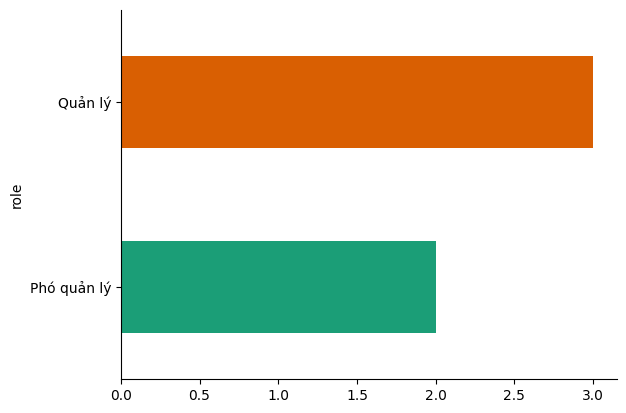

In [12]:
# @title role

from matplotlib import pyplot as plt
import seaborn as sns
rec.groupby('role').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

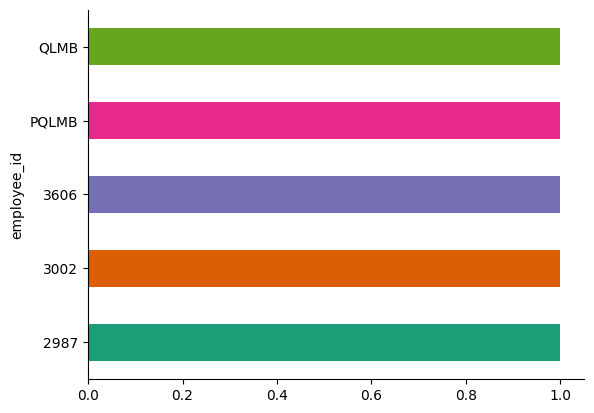

In [11]:
# @title employee_id

from matplotlib import pyplot as plt
import seaborn as sns
rec.groupby('employee_id').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

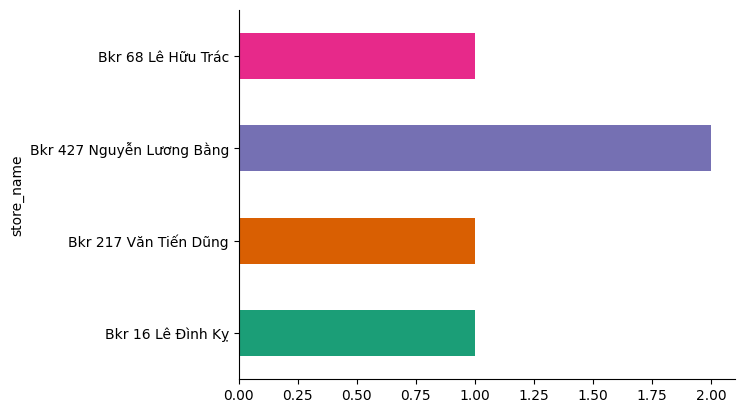

In [10]:
# @title store_name

from matplotlib import pyplot as plt
import seaborn as sns
rec.groupby('store_name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [13]:
import joblib

# Lưu model và preprocessing
joblib.dump(rf_bal, "rf_bal_model.joblib")
joblib.dump(preprocess_bal, "preprocess_bal.joblib")

print("✅ Saved: rf_bal_model.joblib, preprocess_bal.joblib")


✅ Saved: rf_bal_model.joblib, preprocess_bal.joblib


In [14]:
import joblib

# Load model và preprocessing
rf_loaded = joblib.load("rf_bal_model.joblib")
preprocess_loaded = joblib.load("preprocess_bal.joblib")

# Ví dụ dự đoán lại với 1 batch dữ liệu
X_new = preprocess_loaded.transform(df_model.drop(columns=['label']).head(5))
y_new_proba = rf_loaded.predict_proba(X_new)[:,1]
print(y_new_proba)


[0. 0. 0. 0. 0.]
